# Estimating causal effects

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# data_dir = '/content/drive/MyDrive/char_gender/data/'
data_dir = '../data/'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
fig_dir = '../figures/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [4]:
public = pd.read_csv(os.path.join(data_dir, 'public_data.csv'))
public.head()

,Response ID,"If you agree to these conditions, please click ""I consent to participate"" below. If you do not agree, click the “I do not consent to participate” option.\n\nBy agreeing to participate, you confirm that you are over 18 years of age.\n\n \n\nI have read the above information.","In Novel A, how long is the trail that Sam takes?","In Novel A, what plant does Sam rest against?","In Novel B, when does Alex go to the cafe?","In Novel B, what is the material of the chair Alex sketches?",chosen_story,"Your opinion is fundamental to understand reader preferences. Please take your time to answer this question.\n\nIn your own words, briefly share your motivation for your choice (minimum 200 characters, or about 40 words).",Your age:,gender,...,How would you describe your political views?,"In Novel A, when does Alex go to the cafe?","In Novel A, what is the material of the chair Alex sketches?","In Novel B, how long is the trail that Sam takes?","In Novel B, what plant does Sam rest against?",first_gender,first_story,Treatment A,chose_hike,respondent_woman
0,R_7rxJeX0686uzPHi,I consent to participate.,6 miles,Juniper tree,Morning,Wood,Novel A,Novel A has more information about a potential...,25-35,Man,...,Moderate,NaN,NaN,NaN,NaN,W,Hike,Hike,1,0
1,R_1Mng04p43Zl3xvb,I consent to participate.,NaN,NaN,NaN,NaN,Novel B,Novel B drew me in with the suspense of exactl...,36-45,Man,...,Moderate,Morning,Wood,6 miles,Juniper tree,M,Coffee,Hike,1,0
2,R_1IHhRxaGPtHjhQ2,I consent to participate.,6 miles,Juniper tree,Morning,Wood,Novel A,I prefer to read novel A because it was easier...,25-35,Woman,...,Very liberal,NaN,NaN,NaN,NaN,W,Hike,Hike,1,1
3,R_1oFSEE8V2SpwrhD,I consent to participate.,6 miles,Juniper tree,Morning,Wood,Novel B,I'm also interested in art and enjoy a main ch...,18-24,Woman,...,Moderate,NaN,NaN,NaN,NaN,W,Hike,Hike,0,1
4,R_1jVUjK5fbarEH9T,I consent to participate.,6 miles,Juniper tree,Morning,Wood,Novel A,My curiosity about the contents of the note/le...,36-45,Woman,...,Liberal,NaN,NaN,NaN,NaN,W,Hike,Hike,1,1


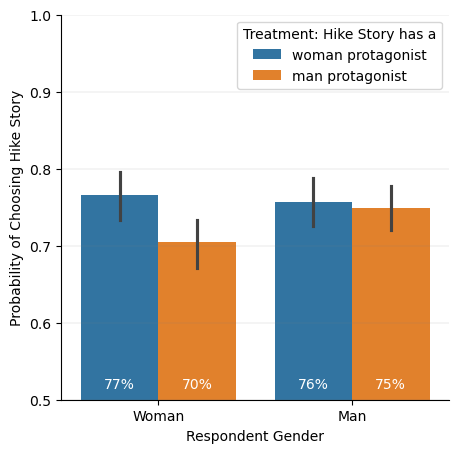

In [5]:
plt.figure(figsize=(5, 5))
ax = sns.barplot(public, x="gender", y="chose_hike", order=['Woman', 'Man'], hue='Treatment A', errorbar=('ci', 95))
ax.set_ylim(0.5, 1)
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['woman protagonist',
                                   'man protagonist'], title='Treatment: Hike Story has a')

for p in ax.patches:
  height = p.get_height()
  if height > 0.5:
    ax.text(p.get_x() + p.get_width() / 2., 0.52, f'{int(round(height, 2) * 100)}%', ha='center', va='center', color='white', fontsize=10) #fontsize = 20


plt.xlabel('Respondent Gender')
plt.ylabel('Probability of Choosing Hike Story')#(r' $\hat{\pi}$ ', rotation=0)
plt.savefig(os.path.join(fig_dir, f'pihats.png'), dpi = 300)
plt.show()

In [6]:
dicts = []
for gender in ['Woman', 'Man']:

  # print(gender.upper())
  subgroup = public[public['gender'] == gender].copy()
  pihat1 = np.mean(subgroup[subgroup['Treatment A'] == 'Hike']['chose_hike'])
  pivar1 = pihat1 * (1 - pihat1)/len(subgroup[subgroup['Treatment A'] == 'Hike'])

  pihat0 = np.mean(subgroup[subgroup['Treatment A'] == 'Other']['chose_hike'])
  pivar0 = pihat0 * (1 - pihat0)/len(subgroup[subgroup['Treatment A'] == 'Other'])

  effect = pihat1-pihat0
  effect_var = pivar1+pivar0
  effect_se = np.sqrt(effect_var)

  cimin = effect - stats.norm.ppf(.975)*effect_se
  cimax = effect + stats.norm.ppf(.975)*effect_se
  d = {'Respondent Gender': gender,
       'effect': effect,
       'cimin': cimin,
       'cimax': cimax}
  dicts.append(d)

  # print(f'pi hat1 {pi_hat1}', f'pi hat0 {pi_hat0}', f'pi hat {pi_hat}')
#print(f'Average treatment effect: {np.average(effects, weights=weights)}')

In [7]:
df = pd.DataFrame(dicts)
df

,Respondent Gender,effect,cimin,cimax
0,Woman,0.061584,0.016927,0.106240
1,Man,0.007931,-0.035845,0.051707


In [8]:
df['effect'].values

array([0.06158358, 0.0079309 ])

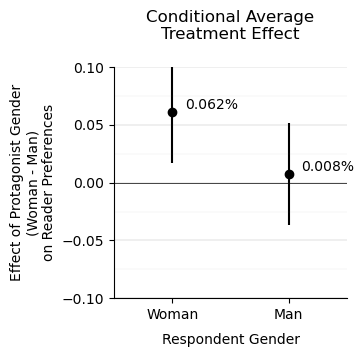

In [9]:
plt.figure(figsize=(3, 3))
plt.xlim(0,2)
plt.ylim(-0.1, 0.1)
plt.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
for pos in ['top', 'right']:
    plt.gca().spines[pos].set_visible(False)

asymmetric_errors = []
for index, row in df.iterrows():
  asymmetric_errors.append([row['effect'] - row['cimin'], row['cimax'] - row['effect']])
plt.errorbar([0.5,1.5], df['effect'].values, yerr=asymmetric_errors, color='black', fmt='o')

for x, y in zip([0.6, 1.6], df['effect'].values):
  plt.text(x+0.01, y, f'{round(y, 3)}%', ha='left', va='bottom', fontsize=10, color='black')

plt.xticks([0.5, 1.5], labels=['Woman', 'Man'])
plt.yticks(np.arange(-0.1, 0.11, step=0.05))
for y in np.arange(-0.1, 0.11, step=0.025):
    plt.axhline(y=y, color='grey', linestyle='-', linewidth=0.25, alpha=0.2)

plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.xlabel('Respondent Gender', labelpad = 8)
plt.ylabel('Effect of Protagonist Gender\n(Woman - Man)\non Reader Preferences')
plt.title('Conditional Average\nTreatment Effect', pad=20)
plt.savefig(os.path.join(fig_dir, f'cate.png'), dpi = 300, bbox_inches = "tight")
plt.show()

## Bootstrapping

In [10]:
# Bootstrap calculations
trials = 1000

bootstrapped_ate = []
bootstrapped_pihat = {'Woman': [],
                      'Man': []}

for i in range(trials):

  effects = []
  weights = []

  for gender in ['Woman', 'Man']:

    subgroup = public[public['gender'] == gender].copy()

    A1 = subgroup[subgroup['Treatment A'] == 'Hike']
    k = len(A1)
    A1_sample = A1.sample(n=k, replace=True)

    A2 = subgroup[subgroup['Treatment A'] == 'Other']
    k = len(A2)
    A2_sample = A2.sample(n=k, replace=True)

    pi_hat1 =  np.mean(A1_sample['chose_hike'])
    pi_hat0 =  np.mean(A2_sample['chose_hike'])
    pi_hat = pi_hat1-pi_hat0

    bootstrapped_pihat[gender].append(pi_hat)
    effects.append(pi_hat)
    weights.append(len(subgroup))

  average_effect = np.average(effects, weights=weights)
  bootstrapped_ate.append(average_effect)

In [11]:
def calculate_CI(bootstrapped):

  sort = sorted(bootstrapped)
  low = round(float(sort[int(trials*0.025)]), 5)
  high = round(float(sort[int(trials*0.975)]), 5)

  return low, high

In [12]:
for k, v in bootstrapped_pihat.items():
  low, high = calculate_CI(v)
  print(f'{trials} Bootstrapped pihat for {k}: ({low}, {high})')

1000 Bootstrapped pihat for Woman: (0.01872, 0.10713)
1000 Bootstrapped pihat for Man: (-0.03746, 0.05004)


# Analyzing demographics

In [13]:
public.columns

Index(['Response ID',
       'If you agree to these conditions, please click "I consent to participate" below. If you do not agree, click the “I do not consent to participate” option.\n\nBy agreeing to participate, you confirm that you are over 18 years of age.\n\n \n\nI have read the above information.',
       'In Novel A, how long is the trail that Sam takes?',
       'In Novel A, what plant does Sam rest against?',
       'In Novel B, when does Alex go to the cafe?',
       'In Novel B, what is the material of the chair Alex sketches?',
       'chosen_story',
       'Your opinion is fundamental to understand reader preferences. Please take your time to answer this question.\n\nIn your own words, briefly share your motivation for your choice (minimum 200 characters, or about 40 words).',
       'Your age:', 'gender', 'Your gender - Prefer to self describe: - Text',
       'What was your total family income before taxes during the past 12 months?',
       'List of Countries', 'Do you

In [14]:
political_views_counts = public['How would you describe your political views?'].value_counts()
political_views_percentages = political_views_counts / political_views_counts.sum() * 100

political_views_table = pd.DataFrame({
    'Political View': political_views_percentages.index,
    'Percentage': political_views_percentages.values
})

# Optional: Define an order for political views if needed for sorting
political_views_order = [
    'Very conservative',
    'Conservative',
    'Moderate',
    'Liberal',
    'Very liberal',
    'Prefer not to disclose'
]
political_views_table['Political View'] = pd.Categorical(political_views_table['Political View'], categories=political_views_order, ordered=True)
political_views_table = political_views_table.sort_values('Political View')


display(political_views_table)

,Political View,Percentage
4,Very conservative,5.499665
3,Conservative,16.130114
1,Moderate,27.162978
0,Liberal,33.266264
2,Very liberal,17.940979


In [15]:
income_counts = public['What was your total family income before taxes during the past 12 months?'].value_counts()
income_percentages = round(income_counts / income_counts.sum() * 100)

income_table = pd.DataFrame({
    'Income Level': income_percentages.index,
    'Percentage': income_percentages.values
})

# Optional: Reorder the table according to the defined income_order
income_order = [
    'Prefer not to disclose',
    'Less than $25,000',
    '$25,000-$49,999',
    '$50,000-$99,999',
    '$100,000-$199,999',
    'More than $200,000'
]
income_table['Income Level'] = pd.Categorical(income_table['Income Level'], categories=income_order, ordered=True)
income_table = income_table.sort_values('Income Level')


display(income_table)

,Income Level,Percentage
5,Prefer not to disclose,2.0
3,"Less than $25,000",11.0
2,"$25,000-$49,999",20.0
0,"$50,000-$99,999",37.0
1,"$100,000-$199,999",25.0
4,"More than $200,000",6.0


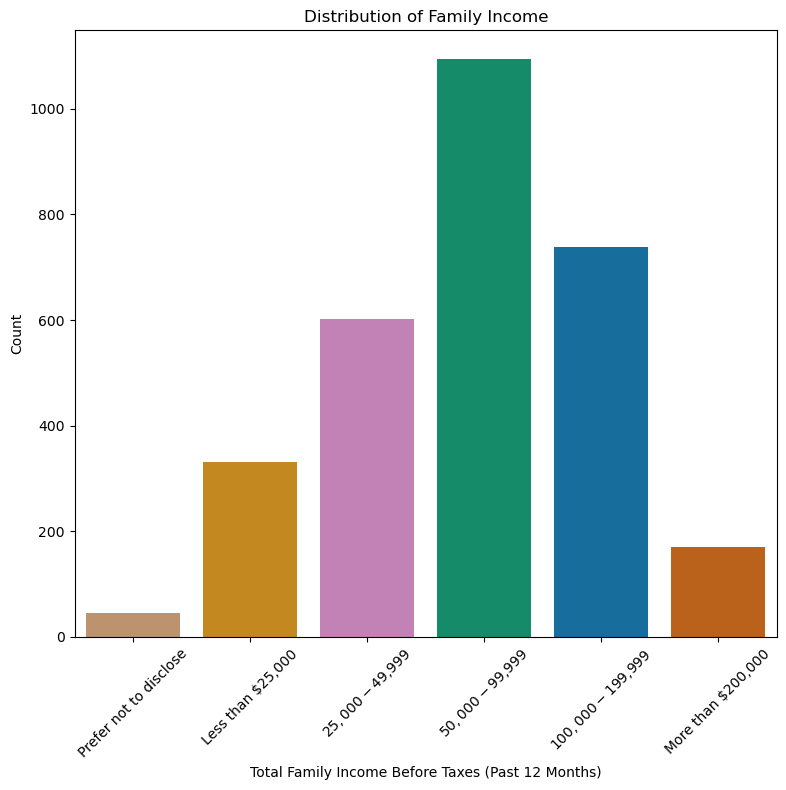

In [16]:
income_order = [
    'Prefer not to disclose',
    'Less than $25,000',
    '$25,000-$49,999',
    '$50,000-$99,999',
    '$100,000-$199,999',
    'More than $200,000'
]

plt.figure(figsize=(8, 8))
sns.countplot(data=public, x='What was your total family income before taxes during the past 12 months?', order=income_order, palette='colorblind', hue='What was your total family income before taxes during the past 12 months?', legend=False)
plt.title('Distribution of Family Income')
plt.xlabel('Total Family Income Before Taxes (Past 12 Months)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
public["Your age:"].value_counts() / public["Your age:"].value_counts().sum()

Your age:
25-35    0.330204
36-45    0.251425
46-55    0.189742
56-65    0.096212
18-24    0.076768
65+      0.055649
Name: count, dtype: float64